In [118]:
import pandas as pd
data = pd.read_csv("fashion_products.csv")

groupedDf = data.groupby('User ID')['Product ID'].apply(list).to_dict()
data

,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M
...,...,...,...,...,...,...,...,...,...
995,20,996,Shoes,Zara,Women's Fashion,55,1.620081,Black,M
996,42,997,Sweater,Nike,Kids' Fashion,13,1.544464,Green,L
997,9,998,Sweater,Zara,Men's Fashion,47,3.961913,White,L
998,8,999,T-shirt,Zara,Women's Fashion,68,3.089722,Blue,S


In [119]:
from surprise import Dataset, Reader, SVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [120]:
contentDf = data[['Product ID', 'Product Name', 'Brand', 'Category', 'Color', 'Size']]
contentDf['Content'] = contentDf.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

vectorizer = TfidfVectorizer()
contentMatrix = vectorizer.fit_transform(contentDf['Content'])

contentSimilarity = linear_kernel(contentMatrix, contentMatrix)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data[['User ID', 'Product ID', 'Rating']], reader)

/var/folders/nd/rxp2phv12xl4m1wk92ksqgxr0000gn/T/ipykernel_5810/2257338889.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contentDf['Content'] = contentDf.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)


In [121]:
def getContentBasedRecommendations(productId, topN):
    index = contentDf[contentDf['Product ID'] == productId].index[0]
    similarityScores = contentSimilarity[index]
    similarIndices = similarityScores.argsort()[::-1][1:topN + 1]
    recs = contentDf.loc[similarIndices, 'Product ID'].values
    return recs

In [122]:
svd = SVD()
trainSet = data.build_full_trainset()
svd.fit(trainSet)

def getCollaborativeFilteringRecommendations(userId, topN):
    testSet = trainSet.build_anti_testset()
    testSet = filter(lambda x: x[0] == userId, testSet)
    predicts = svd.test(testSet)
    predicts.sort(key=lambda x: x.est, reverse=True)
    recs = [prediction.iid for prediction in predicts[:topN]]
    return recs

In [123]:
def getHybridRecs(userId, productId, topN):
    contentBasedRecs = getContentBasedRecommendations(productId, topN)
    collaborativeFilteringRecs = getCollaborativeFilteringRecommendations(userId, topN)
    
    recs = list(set(contentBasedRecs + collaborativeFilteringRecs))
    return recs[:topN]


In [124]:
userId = 1
productId = 1
topN = 5

hybridRecs = getHybridRecs(userId, productId, topN)

hybridRecs

[96, 518, 682, 974, 540]

In [125]:
getCollaborativeFilteringRecommendations(userId, topN)

[677, 534, 93, 145, 29]

In [126]:
getContentBasedRecommendations(productId, topN).tolist()

[5, 6, 3, 829, 489]

In [137]:
import numpy as np
from surprise.model_selection import cross_validate
from surprise import Prediction

def getMean(tup):
    return (tup[0] + tup[1] + tup[2]) / 3

info = { 
    "hybrid": {
        "reg": {"rmse": [], "mae": []}, 
        "epochs": {"rmse": [], "mae": []}
    },
    "svd": {
        "reg": {"rmse": [], "mae": []}, 
        "epochs": {"rmse": [], "mae": []}
    }
}

class Hybrid(SVD):

    def predict(self, uid, iid, r_ui=None, clip=True, verbose=False):
        cf_prediction = super(Hybrid, self).predict(uid, iid, r_ui=r_ui, clip=clip, verbose=verbose)

        content_based_prediction = self.content_based_predict(uid, iid)

        hybrid_prediction_value = 0.9 * cf_prediction.est + 0.1 * content_based_prediction

        hybrid_prediction = Prediction(uid, iid, r_ui, hybrid_prediction_value, details={})
        return hybrid_prediction

    def content_based_predict(self, uid, iid):
        # короче... Берем объект, которому хотим сказать, насколько бы мы его посоветовали.
        # если реки по нему включают уже купленный товар -- советуем, иначе -- не советуем
        recs = set(getContentBasedRecommendations(iid, 40))
        if (recs & set(groupedDf[uid]) == True): 
            res = 1 
        else:  
            res = 0
        
        return res
        
    

lrs = np.arange(0.001, 0.1, 0.001)
regs = np.arange(0.001, 0.1, 0.001)
n_epochs = np.arange(10, 510, 10)

for reg in regs:
    algo = Hybrid(reg_all=reg)

    res = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, n_jobs=3)
    info["hybrid"]["reg"]["rmse"].append(getMean(res["test_rmse"]))
    info["hybrid"]["reg"]["mae"].append(getMean(res["test_mae"]))
    
    algo = SVD(reg_all=reg)

    res = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, n_jobs=3)
    info["svd"]["reg"]["rmse"].append(getMean(res["test_rmse"]))
    info["svd"]["reg"]["mae"].append(getMean(res["test_mae"]))

for epochs in n_epochs:
    algo = Hybrid(n_epochs = epochs)

    res = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, n_jobs=3)
    info["hybrid"]["epochs"]["rmse"].append(getMean(res["test_rmse"]))
    info["hybrid"]["epochs"]["mae"].append(getMean(res["test_mae"]))
    
    algo = SVD(n_epochs = epochs)

    res = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, n_jobs=3)
    info["svd"]["epochs"]["rmse"].append(getMean(res["test_rmse"]))
    info["svd"]["epochs"]["mae"].append(getMean(res["test_mae"]))


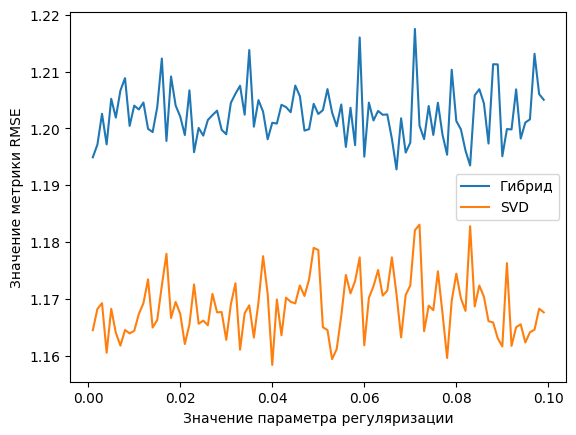

In [138]:
import matplotlib.pyplot as plt

plt.plot(regs, info["hybrid"]["reg"]["rmse"], label="Гибрид")
plt.plot(regs, info["svd"]["reg"]["rmse"], label="SVD")

plt.legend()
plt.ylabel("Значение метрики RMSE")
plt.xlabel("Значение параметра регуляризации")
plt.show()

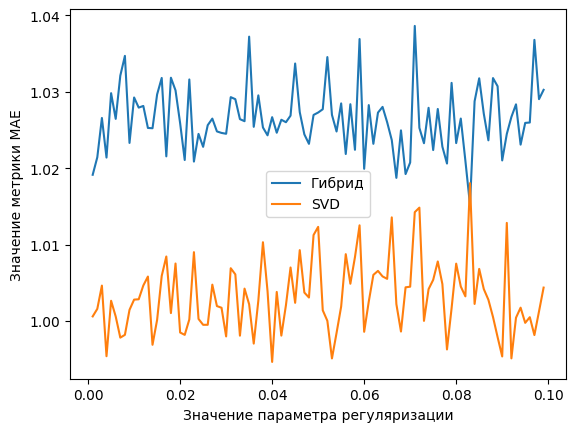

In [139]:

import matplotlib.pyplot as plt

plt.plot(regs, info["hybrid"]["reg"]["mae"], label="Гибрид")
plt.plot(regs, info["svd"]["reg"]["mae"], label="SVD")

plt.legend()
plt.ylabel("Значение метрики MAE")
plt.xlabel("Значение параметра регуляризации")
plt.show()

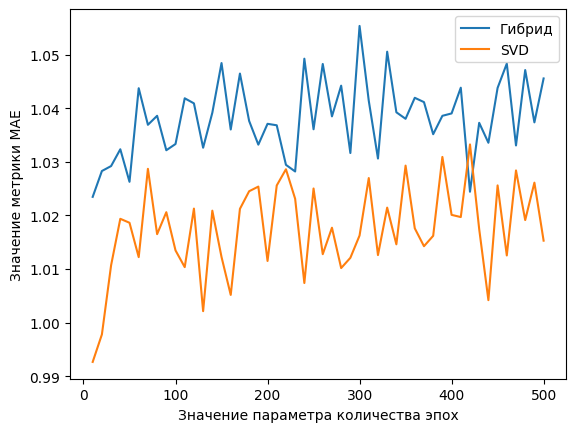

In [140]:

import matplotlib.pyplot as plt

plt.plot(n_epochs, info["hybrid"]["epochs"]["mae"], label="Гибрид")
plt.plot(n_epochs, info["svd"]["epochs"]["mae"], label="SVD")

plt.legend()
plt.ylabel("Значение метрики MAE")
plt.xlabel("Значение параметра количества эпох")
plt.show()

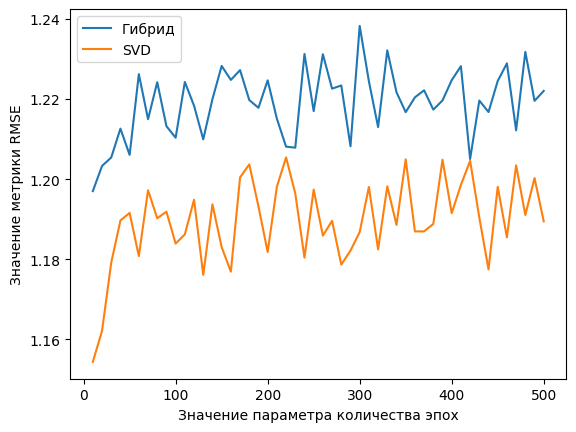

In [141]:
import matplotlib.pyplot as plt

plt.plot(n_epochs, info["hybrid"]["epochs"]["rmse"], label="Гибрид")
plt.plot(n_epochs, info["svd"]["epochs"]["rmse"], label="SVD")

plt.legend()
plt.ylabel("Значение метрики RMSE")
plt.xlabel("Значение параметра количества эпох")
plt.show()